In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, KFold
from colors import BLUE, ORANGE, PURPLE
from datasets.prostate import X_train, y_train
from models import (
    BestSubsetRegression,
    PrincipalComponentsRegression,
    PartialLeastSquares,
)

In [2]:
class OneStandardErrorCV(GridSearchCV):
    
    def __init__(
        self, estimator, param_name, param_values,
        n_splits=10, random_state=69438,
    ):
        self.estimator = estimator
        self.param_name = param_name
        self.param_values = param_values
        self.n_splits = n_splits
        self.random_state = random_state
        super().__init__(
            self.estimator, {self.param_name: self.param_values},
            cv=KFold(self.n_splits, shuffle=True, random_state=self.random_state),
            scoring='neg_mean_squared_error',
        )
    
    def fit(self, X, y=None):
        super().fit(X, y)
        cv_err = -np.vstack([
            self.cv_results_[f'split{k}_test_score']
            for k in range(self.n_splits)
        ])
        self.cv_err_mean = np.mean(cv_err, axis=0)
        self.cv_err_std = np.std(cv_err, ddof=1, axis=0) / np.sqrt(self.n_splits)
        best_idx = np.argmin(self.cv_err_mean)
        self.model_idx_ = np.argmax(
            self.cv_err_mean < self.cv_err_mean[best_idx] + self.cv_err_std[best_idx]
        )
        return self

In [3]:
def plot_cv_err(reg, param_name, param_values):
    base = OneStandardErrorCV(DummyRegressor(), 'constant', [None])
    base.fit(X_train, y_train)
    cv = OneStandardErrorCV(reg, param_name, param_values)
    cv.fit(X_train, y_train)
    fig, ax = plt.subplots()
    pd.Series(
        data=np.hstack([base.cv_err_mean, cv.cv_err_mean]),
    ).plot(ax=ax, color=ORANGE, style='.-')
    ax.errorbar(
        x=range(len(param_values) + 1),
        y=np.hstack([base.cv_err_mean, cv.cv_err_mean]),
        yerr=np.hstack([base.cv_err_std, cv.cv_err_std]),
        ecolor=BLUE, elinewidth=1, capsize=5, linestyle='None',
    )
    ax.axvline(
        x=cv.model_idx_ + 1, color=PURPLE,
        linestyle='--', linewidth=1,
    )
    ax.axhline(
        y=cv.cv_err_mean[cv.model_idx_], color=PURPLE,
        linestyle='--', linewidth=1,
    )
    ax.set_xlabel(param_name)
    ax.set_xticks(range(len(param_values) + 1))
    ax.set_xticklabels(['base'] + [str(v) for v in param_values])
    ax.set_ylabel("CV Error")
    ax.set_title(re.sub(r'([a-z])([A-Z])', r'\1 \2', type(reg).__name__))

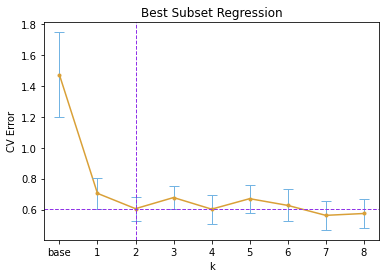

In [4]:
plot_cv_err(
    BestSubsetRegression(),
    'k', range(1, X_train.shape[1] + 1),
)

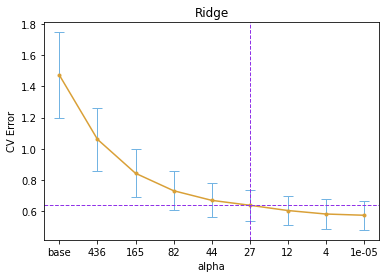

In [5]:
plot_cv_err(
    Ridge(),
    'alpha', [436, 165, 82, 44, 27, 12, 4, 1e-05],
)

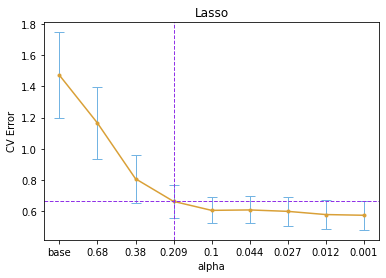

In [6]:
plot_cv_err(
    Lasso(),
    'alpha', [0.680, 0.380, 0.209, 0.100, 0.044, 0.027, 0.012, 0.001],
)

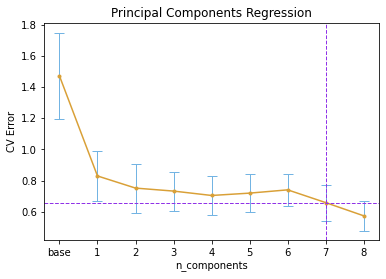

In [7]:
plot_cv_err(
    PrincipalComponentsRegression(),
    'n_components', range(1, X_train.shape[1] + 1),
)

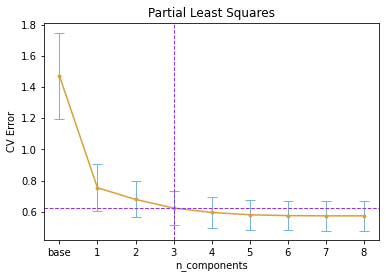

In [8]:
plot_cv_err(
    PartialLeastSquares(),
    'n_components', range(1, X_train.shape[1] + 1),
)